# Importing necessary libraries

In [1]:
#pip install xgboost

In [59]:
#Data Manipulation and handeling
import pandas as pd
import numpy as np

#Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

#Multicollinearity Test and Teatment Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

#Data Preprocessing and EDA Libraries
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

#Model Selection Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve

#ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

#Model Evaluation Libraries
from sklearn.metrics import r2_score, mean_squared_error

#Unsupervised ML library
from sklearn.cluster import KMeans


#Warning filter library
import warnings
warnings.filterwarnings('ignore')

## Loading the DataFrame

In [3]:
df = pd.read_excel('Capstone Project.xlsx')
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


## Exploratory Data Analysis(EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Observations from df.info()
1) There are no-null values.
2) 1030 rows and 9 columns.
3) Except age all the columns datatype is int.
4) Dependent variable 1-strength and rest are independent.



In [5]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


Analysis from Descriptive Statistics:

1. There might be skewness in the data in the columns.
2. There might be chance of outliers if we compare Quartiles of some of the columns.(age,cement,slag,superplastic,strength in the upper whisker region)
3. Since minimum and Q1 values are same for slag and ash we do not have outliers in the Lower Whisker region for them.
4. The range of values in age is from 1-365 we can say that the values in days.

### Building a Custom Summary function for EDA Report 

In [6]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'Feature Name': col , 
                'Count': my_df[col].count() ,
                'Minimum': my_df[col].min() ,
                'Quartile1': my_df[col].quantile(.25) ,
                'Quartile2': my_df[col].quantile(.50) ,
                'Mean': my_df[col].mean() ,
                'Quartile 3': my_df[col].quantile(.75) ,
                'Maximum': my_df[col].max() ,
                'Variance': round(my_df[col].var()) ,
                'Standard Deviation': my_df[col].std() ,
                'Skewness': my_df[col].skew() , 
                'Kurtosis': my_df[col].kurt()
                })
            result.append(stats)
    result_df = pd.DataFrame(result)
    #Skewness type: 
    skewness_label = []
    for i in result_df['Skewness']:
        if i <= -1:
            skewness_label.append('Highly Negatively Skewed')
        elif -1 < i <= -0.5:
            skewness_label.append('Moderately Negatively Skewed')
        elif -0.5 < i < 0:
            skewness_label.append('Fairly Negatively Skewed')
        elif 0 <= i < 0.5:
            skewness_label.append('Fairly Positively Skewed')
        elif 0.5 <= i < 1:
            skewness_label.append('Moderately Positively Skewed')
        elif i >= 1:
            skewness_label.append('Highly Positively Skewed')
    result_df['Skewness Comment'] = skewness_label
    kurtosis_label = []
    for i in result_df['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result_df['Kurtosis Comment'] = kurtosis_label
    Outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            Q1 = my_df[col].quantile(0.25)
            Q2 = my_df[col].quantile(0.5)
            Q3 = my_df[col].quantile(0.75)
            IQR = Q3 - Q1
            LW = Q1 - 1.5*IQR
            UW = Q3 + 1.5*IQR
            if len(my_df[(my_df[col] < LW) | (my_df[col] > UW)]) > 0:
                Outliers_label.append('Have Outliers')
            else:
                Outliers_label.append('No Outliers')
    result_df['Outlier Comment'] = Outliers_label

            
    return result_df




In [7]:
custom_summary(df)

,Feature Name,Count,Minimum,Quartile1,Quartile2,Mean,Quartile 3,Maximum,Variance,Standard Deviation,Skewness,Kurtosis,Skewness Comment,Kurtosis Comment,Outlier Comment
0,cement,1030,102.00,192.375,272.900,281.167864,350.000,540.0,10922,104.506364,0.509481,-0.520652,Moderately Positively Skewed,Mesokurtic Curve,No Outliers
1,slag,1030,0.00,0.000,22.000,73.895825,142.950,359.4,7444,86.279342,0.800717,-0.508175,Moderately Positively Skewed,Mesokurtic Curve,Have Outliers
2,ash,1030,0.00,0.000,0.000,54.188350,118.300,200.1,4096,63.997004,0.537354,-1.328746,Moderately Positively Skewed,Platykurtic Curve,No Outliers
3,water,1030,121.80,164.900,185.000,181.567282,192.000,247.0,456,21.354219,0.074628,0.122082,Fairly Positively Skewed,Mesokurtic Curve,Have Outliers
4,superplastic,1030,0.00,0.000,6.400,6.204660,10.200,32.2,36,5.973841,0.907203,1.411269,Moderately Positively Skewed,Leptokurtic Curve,Have Outliers
5,coarseagg,1030,801.00,932.000,968.000,972.918932,1029.400,1145.0,6046,77.753954,-0.040220,-0.599016,Fairly Negatively Skewed,Mesokurtic Curve,No Outliers
6,fineagg,1030,594.00,730.950,779.500,773.580485,824.000,992.6,6428,80.175980,-0.253010,-0.102177,Fairly Negatively Skewed,Mesokurtic Curve,Have Outliers
7,age,1030,1.00,7.000,28.000,45.662136,56.000,365.0,3990,63.169912,3.269177,12.168989,Highly Positively Skewed,Leptokurtic Curve,Have Outliers
8,strength,1030,2.33,23.710,34.445,35.817961,46.135,82.6,279,16.705742,0.416977,-0.313725,Fairly Positively Skewed,Mesokurtic Curve,Have Outliers


Analysis From Custom-Summary
1) Cement, ash , coarse-egg have no outliers,
2) 

## Performing Outlier Treatment

In [8]:
def replace_outlier(my_df , col , method = 'Quartile' , strategy = 'Median'):
    col_data = my_df[col]
    
    if method == 'Quartile':
        #Using quartiles to calculate IQR
        q1 = col_data.quantile(0.25)
        q2 = col_data.quantile(0.5)
        q3 = col_data.quantile(0.75)

        IQR = q3 - q1
        LW = q1 - 1.5*IQR
        UW = q3 + 1.5*IQR
        
    elif method == 'Standard Deviation':
        mean = col_data.mean()
        std = col_data.std()
        LW = mean - 2*std
        UW = mean + 2*std
    else:
        print('Pass a correct method')
    
    #printing all the outliers
    
    outliers = my_df. loc[(col_data < LW) | (col_data > UW)]
    outlier_density = round(len(outliers)/len(my_df) , 2) * 100
    if len(outliers) == 0:
        print(f'Feature {col} doesnot have any outliers')
        print('\n')
    else:
        print(f'Feature {col} Has outliers')
        print('\n')
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'outlier percentage in {col} is {outlier_density}%')
        print('\n')
        display(my_df[(col_data < LW) | (col_data > UW)])
        
    #Replacing outliers 
    if strategy == 'Median':
        my_df.loc[(col_data < LW) | (col_data > UW) , col] = q2
    elif strategy == 'Mean':
         my_df.loc[(col_data < LW) | (col_data > UW) , col] = mean
    else:
        print('pass a correct strategy')
        
        
    return my_df

## ODT Plots

1. Descriptive plots.
2. Histogram with Outliers.
3. Histogram Without Outliers.

In [9]:
def odt_plots(my_df , col):
    f , (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,8))
    
    #Descriptive Statistics boxplot
    sns.boxplot(my_df[col], ax = ax1)
    ax1.set_title(col + 'Boxplot')
    ax1.set_xlabel('values')
    ax1.set_ylabel('Boxplot')
    
    #Plotting Histogram with outliers
    sns.distplot(my_df[col] , ax = ax2, fit =sci.norm) #On histogram i am fitting normal Distribution plot
    ax2.axvline(my_df[col].mean() , color = 'green')
    ax2.axvline(my_df[col].median() , color = 'brown')
    ax2.set_title(col + 'Histogram with outliers')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('values')
    
    #replacing outliers 
    df_out = replace_outlier(my_df , col)
    
    #Plotting Histogram with outliers
    sns.distplot(df_out[col] , ax = ax3, fit =sci.norm) #On histogram i am fitting normal Distribution plot
    ax2.axvline(df_out[col].mean() , color = 'green')
    ax2.axvline(df_out[col].median() , color = 'brown')
    ax2.set_title(col + 'Histogram without outliers')
    ax2.set_ylabel('Density')
    ax2.set_xlabel('values')
    plt.show
    
    
    

Feature cement doesnot have any outliers


Feature slag Has outliers


Total number of outliers in slag are 2


outlier percentage in slag is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
918,239.6,359.4,0.0,185.7,0.0,941.6,664.3,28,39.44
990,239.6,359.4,0.0,185.7,0.0,941.6,664.3,7,25.42


Feature ash doesnot have any outliers


Feature water Has outliers


Total number of outliers in water are 9


outlier percentage in water is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
66,237.0,92.0,71.0,247.0,6.0,853.0,695.0,28,28.63
263,236.9,91.7,71.5,246.9,6.0,852.9,695.4,28,28.63
432,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,28,24.24
462,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,100,39.23
587,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,3,7.75
740,140.0,164.0,128.0,237.0,6.0,869.0,656.0,28,35.23
789,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,56,32.85
826,139.7,163.9,127.7,236.7,5.8,868.6,655.6,28,35.23
914,168.0,42.1,163.8,121.8,5.7,1058.7,780.1,14,17.82


Feature superplastic Has outliers


Total number of outliers in superplastic are 10


outlier percentage in superplastic is 1.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.2
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.4
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.3
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.7
538,531.3,0.0,0.0,141.8,28.2,852.1,893.7,7,46.9
744,469.0,117.2,0.0,137.8,32.2,852.1,840.5,7,54.9
816,469.0,117.2,0.0,137.8,32.2,852.1,840.5,28,66.9
838,531.3,0.0,0.0,141.8,28.2,852.1,893.7,56,58.8
955,469.0,117.2,0.0,137.8,32.2,852.1,840.5,3,40.2
1026,531.3,0.0,0.0,141.8,28.2,852.1,893.7,3,41.3


Feature coarseagg doesnot have any outliers


Feature fineagg Has outliers


Total number of outliers in fineagg are 5


outlier percentage in fineagg is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.5
447,375.0,93.8,0.0,126.6,23.4,852.1,992.6,7,45.7
504,375.0,93.8,0.0,126.6,23.4,852.1,992.6,3,29.0
584,375.0,93.8,0.0,126.6,23.4,852.1,992.6,56,60.2
857,375.0,93.8,0.0,126.6,23.4,852.1,992.6,28,56.7


Feature age Has outliers


Total number of outliers in age are 59


outlier percentage in age is 6.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,228.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,228.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,228.0,0.0,932.0,670.0,180,53.10
133,236.0,0.0,0.0,193.0,0.0,968.0,885.0,365,25.08
144,302.0,0.0,0.0,203.0,0.0,974.0,817.0,180,26.74
149,380.0,95.0,0.0,228.0,0.0,932.0,594.0,270,41.15
152,322.0,0.0,0.0,203.0,0.0,974.0,800.0,180,29.59
157,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


Feature strength Has outliers


Total number of outliers in strength are 4


outlier percentage in strength is 0.0%




,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
732,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
950,389.9,189.0,0.0,145.9,22.0,944.7,755.8,91,82.60
1003,323.7,282.8,0.0,183.8,10.3,942.7,659.9,56,80.20


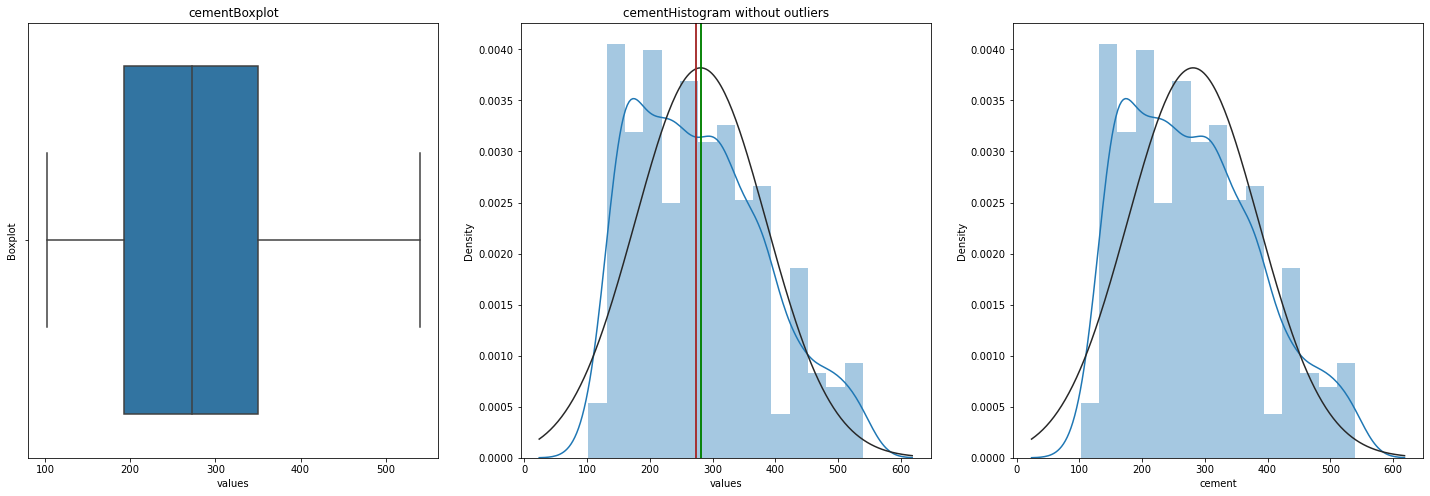

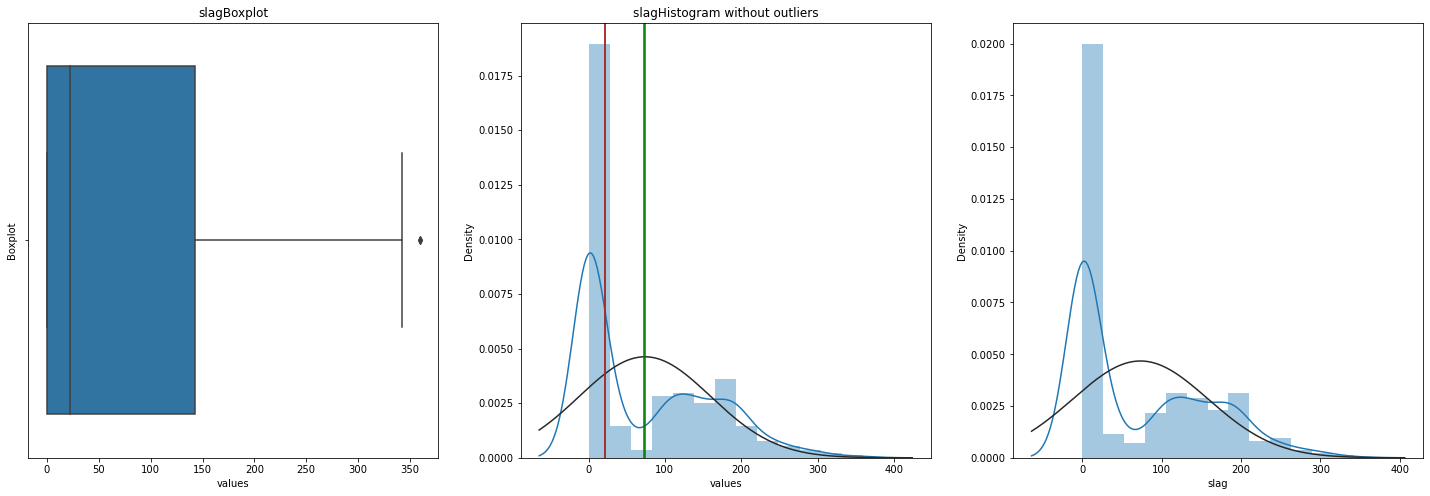

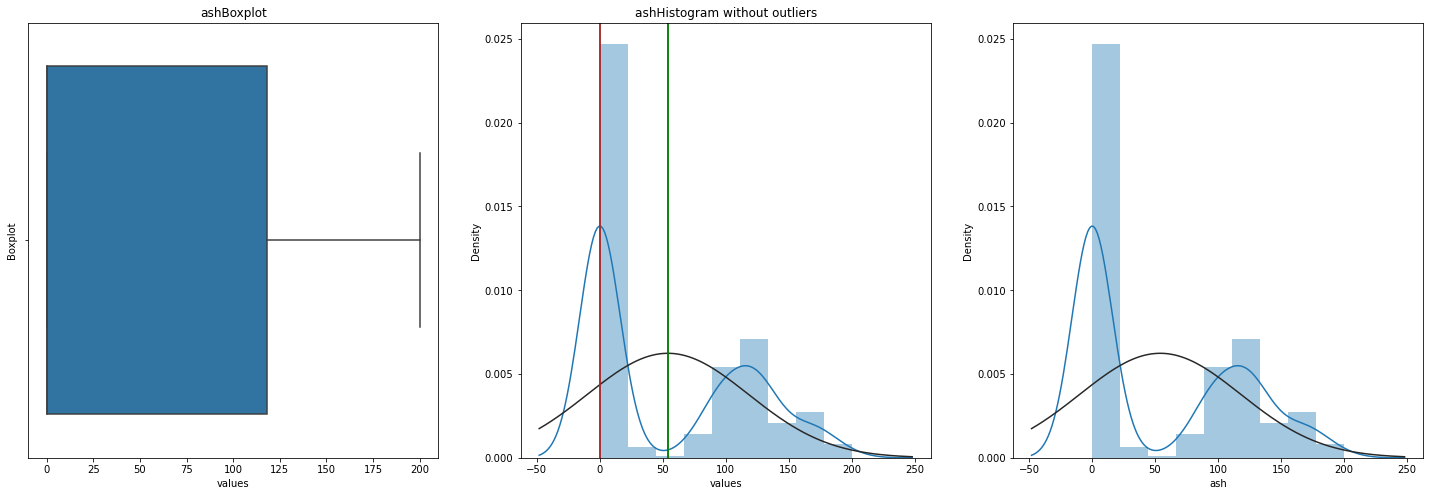

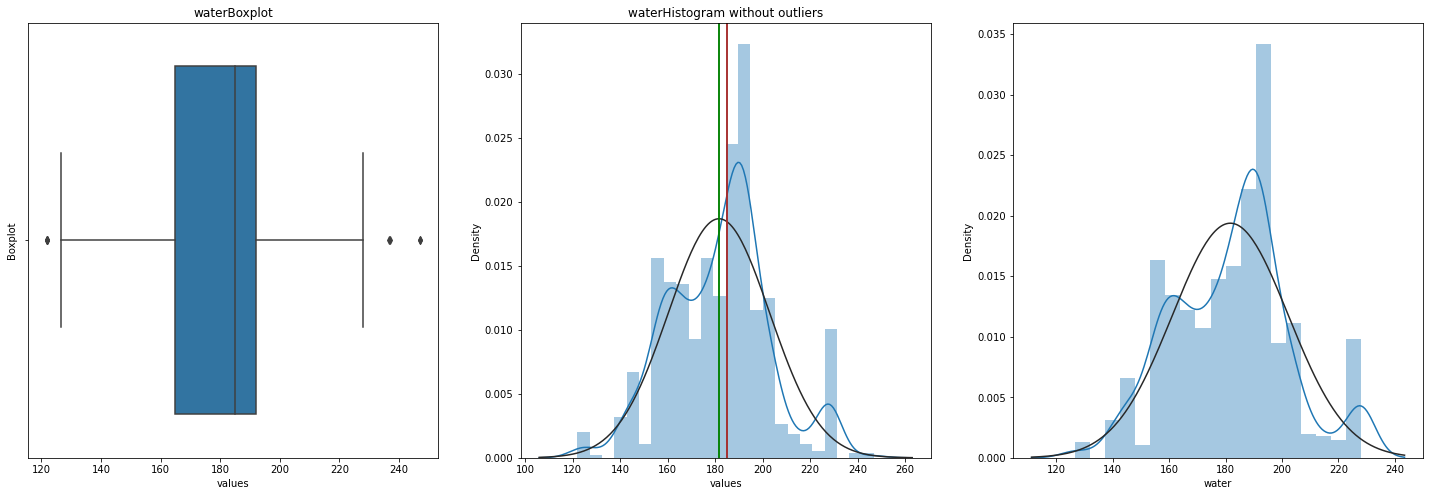

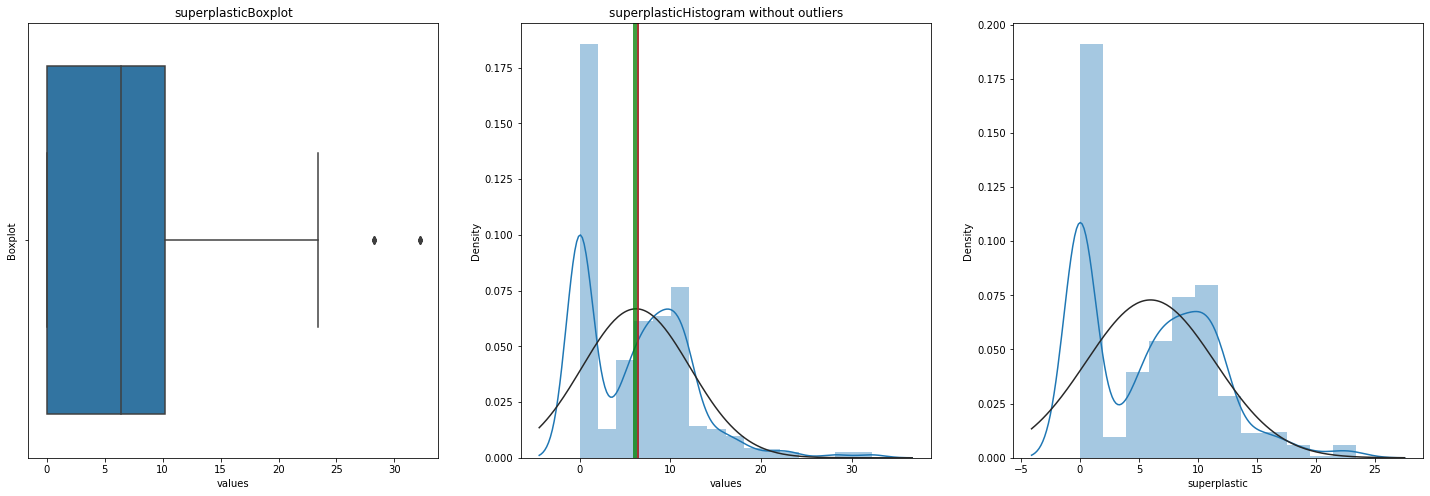

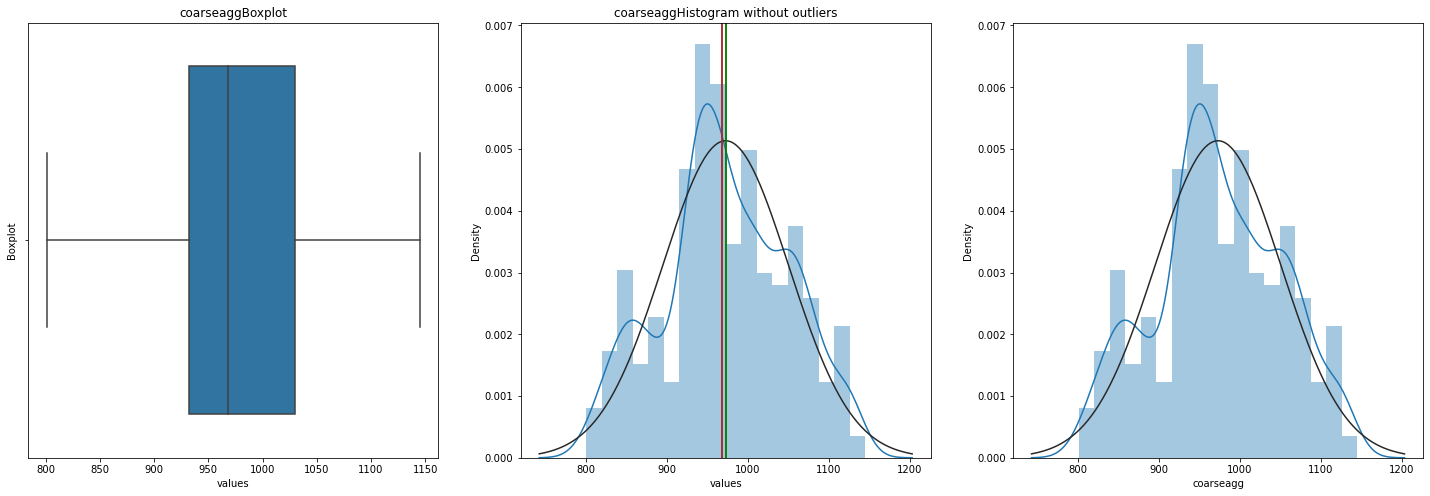

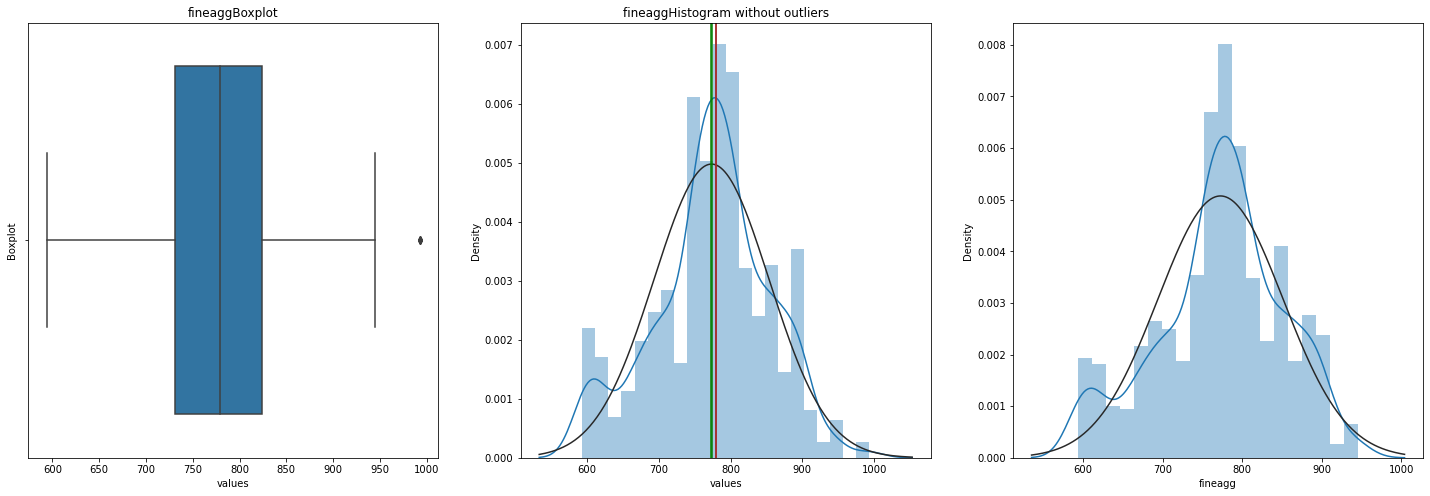

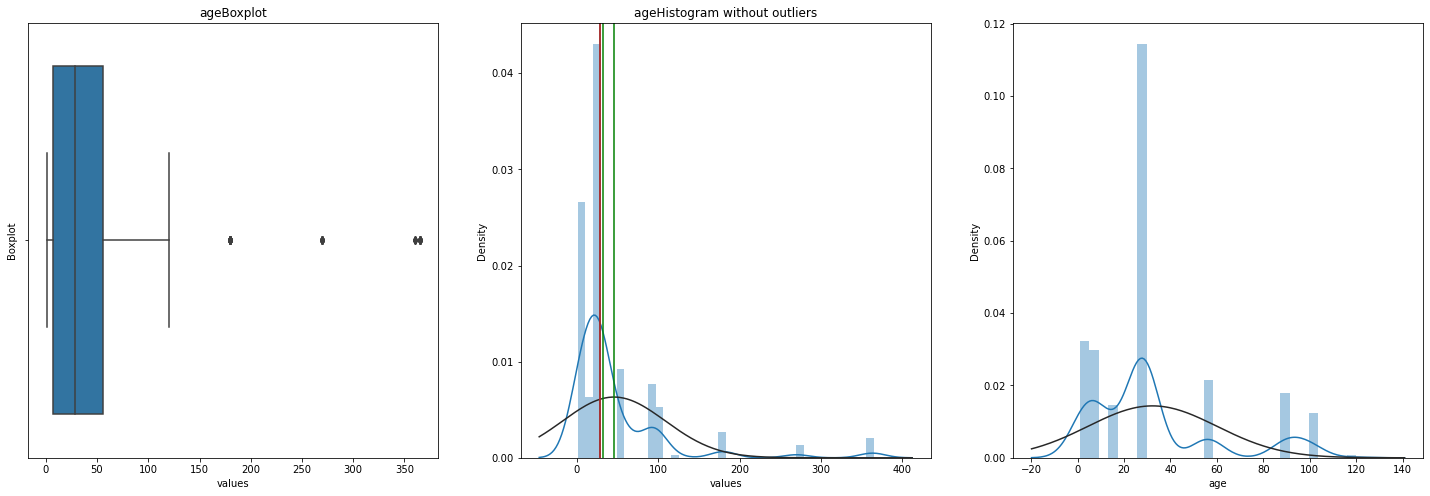

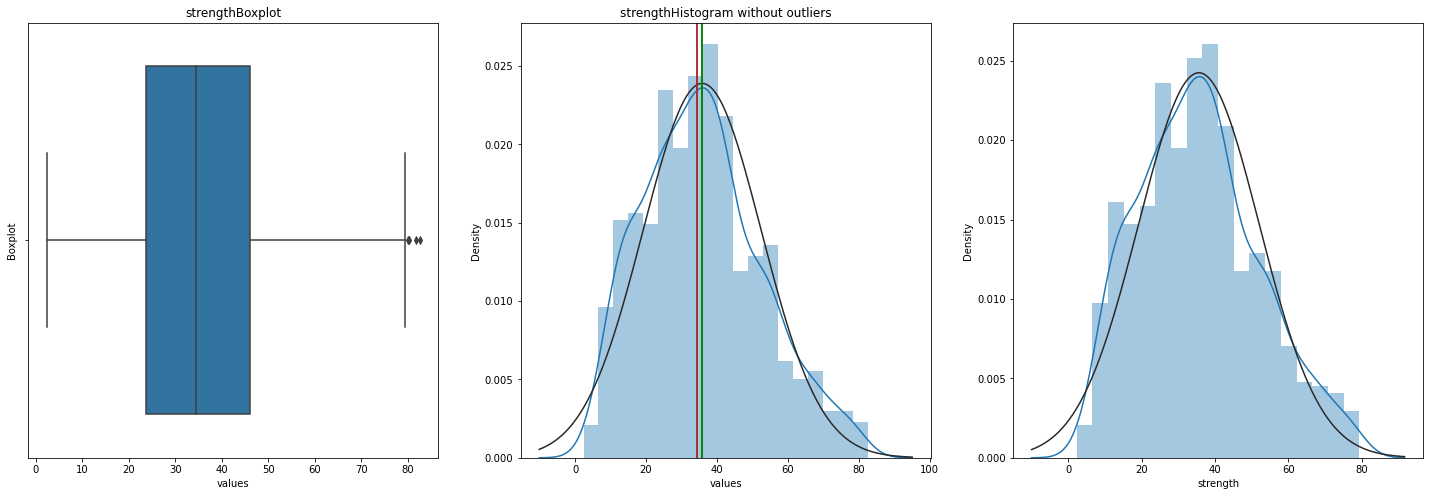

In [10]:
for col in df.columns:
    odt_plots(df , col)

## Multivariate Analysis Using Regression

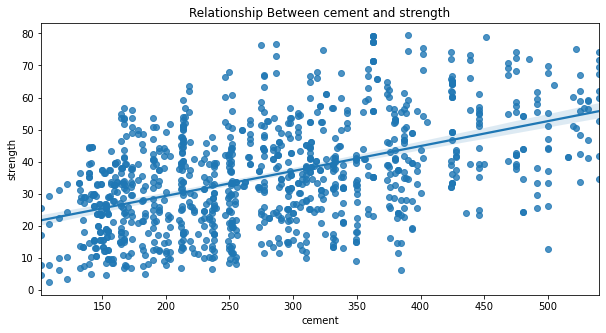

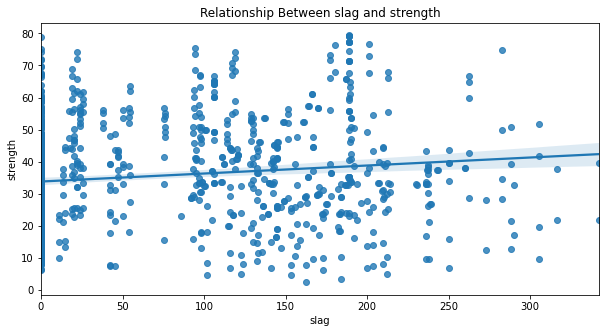

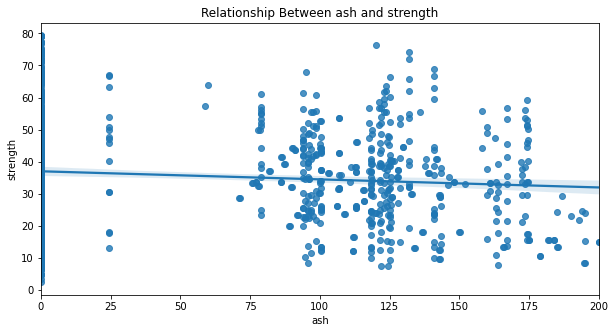

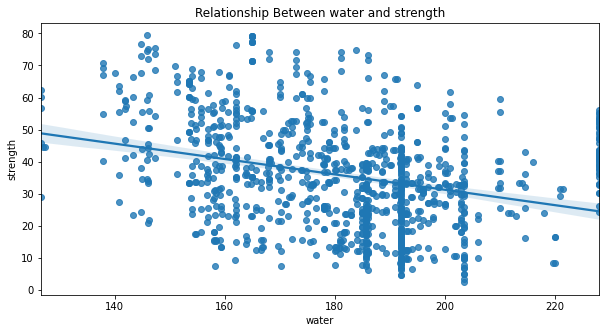

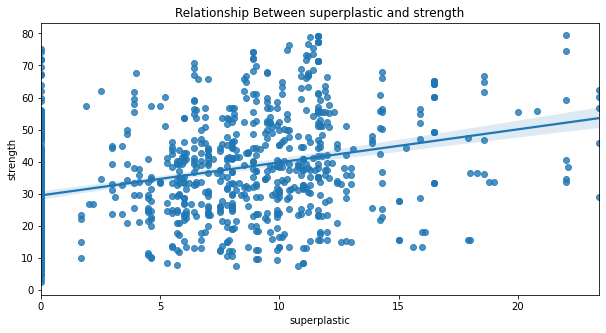

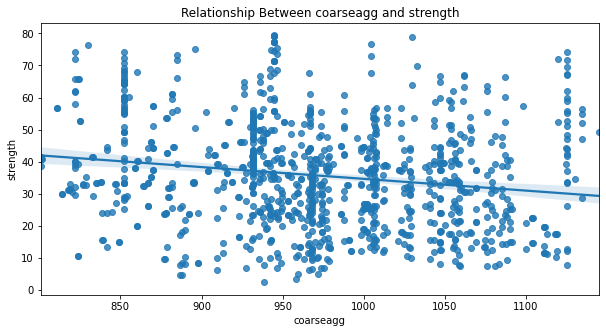

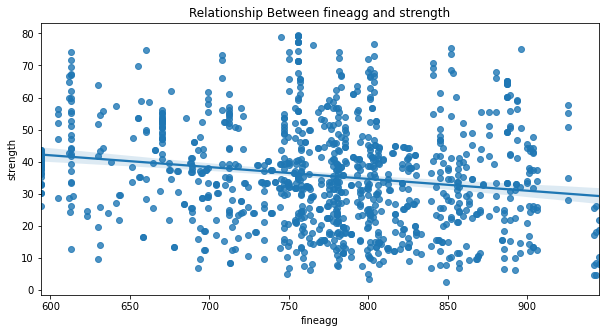

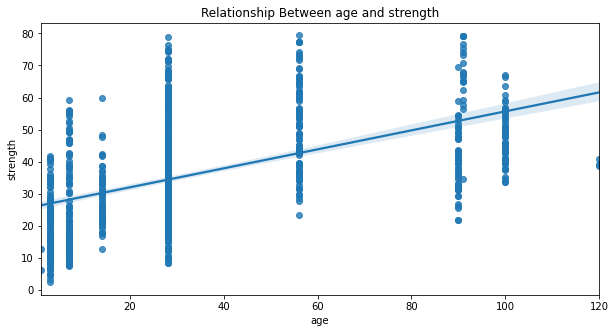

In [11]:
for col in df.columns:
    if col != 'strength':
        fig , ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col] , y = df['strength'] , ax = ax1).set_title(f'Relationship Between {col} and strength')
                                                                           


Analysis from Regression plots:

1. Strength and cement are highly positively correlated.
2. Strength and slag are slightly positively correlated.
3. Strength and ash are slightly negatively correlated.
4. Strength and water are highly negatively correlated.
5. Superplastic and stength are highly postively correlated.
6. Coarseegg and strength are slightly negatively correlated. 
7. fineegg and strength are highly negatively correlated.
8. Age and strength are highly positively correlated.

## Multicollinearity Test
- Correlation Matrix/ HeatMap(Stage 1)

<AxesSubplot:>

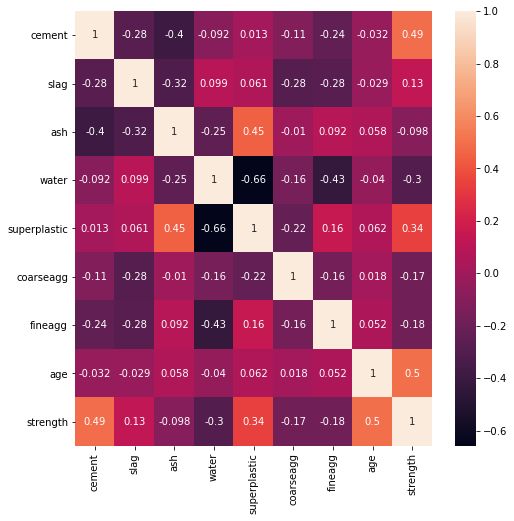

In [12]:
corr= df.corr()
df.ax = plt.subplots(figsize = (8,8))
sns.heatmap(corr, annot = True)

 Analysis / Results from stage 1 test:
 1. Slag has high correlation with ash.
 2. Ash has high correlation with cement, ash, superplastics
 3. water has high correlation with superplastics, fineagg.
 4. superplastics has high correlation with ash, water.
 - Many feature have correlation more than 30% so we can conclude stage 1 results that there is a chance of multicollinearity in the data.

## Multicollinearity Test
- Variance inflation Factor(VIF)
Formula for VIF is = 1 / (1-R2)

steps:
1. Regress every indepedent variable with each other and calculate the R2
2. Find VIF using above formula.
3. If VIF is more than 5 , we say that multicollinearity exists.


def VIF(features):
    vif = pd.DataFrame()
    vif['vif'] = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    vif['features'] = features.columns
    return vif

def VIF_1(features):
    vif = pd.DataFrame(columns = ['vif', 'features'])
    vif.iloc[:,0] = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    vif.iloc[:,1] = features.columns
    return vif


VIF(df.drop('strength', axis = 1))


Analysis from stage 2 result
1. Five features have VIF more than 5, so we can conclude that multicollinearity exist in this data.


## Correlation with the target feature


In [13]:
def correlation_with_tagret(data, t_col):
    independent_variable = data.drop(t_col, axis =1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variable, corr_result], index= ['Independent Variables', 'correlation']).T
    return result.sort_values('correlation', ascending = False)

In [14]:
correlation_with_tagret(df, 'strength')

,Independent Variables,correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


Analysis
1. Age and cement have a 49% correlation with strength.
2. superplastic and water have 34% and 30% correlation with strength.

## Applying PCA to treat Multicollinearity


In [15]:
def custom_PCA(X):
    n_comp=len(X.columns)
    
    #Appyling StandardScaler for Feature Scaling
    sc = StandardScaler()
    X = sc.fit_transform(X)
    
    for i in range(1,n_comp):
        pca=PCA(n_components=i)
        p_comp=pca.fit_transform(X)
        evr=np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1]>0.9:
            pcs=i
            break
    print('Explained Variance ratio after PCA is: ', evr)
    #Crearing a dataframe of principal components
    col=[]
    for j in range(1,pcs+1):
        col.append('PC_'+str(j))
    pca_df=pd.DataFrame(p_comp,columns=col)
    return pca_df

In [16]:
pca_df = custom_PCA(df.drop('strength', axis=1))

Explained Variance ratio after PCA is:  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [17]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228


### Joining PCA features with Target Features


In [18]:
pca_df = pca_df.join(df['strength'], how = 'left')

In [19]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PC_1      1030 non-null   float64
 1   PC_2      1030 non-null   float64
 2   PC_3      1030 non-null   float64
 3   PC_4      1030 non-null   float64
 4   PC_5      1030 non-null   float64
 5   PC_6      1030 non-null   float64
 6   strength  1030 non-null   float64
dtypes: float64(7)
memory usage: 56.5 KB


In [20]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


## Model Building 
- Custom train-test-split function
- Cross-validation
- Hyperparameter Tuning


In [22]:
def train_and_test_split(data, tcol, testSize = 0.3, randomState = 3):
    X = data.drop(tcol, axis = 1)
    y = data[tcol]
    return train_test_split(X,y,test_size = testSize, random_state = randomState)

In [23]:
def model_builder(model_name, model, data, t_col):
    X_train, X_test, y_train, y_test = train_and_test_split(data, t_col)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name , rmse, r2]
    return result

In [24]:
model_builder(model_name = 'LinearRegression' , model = LinearRegression(), data = pca_df, t_col = 'strength')

['LinearRegression', 9.098029413143962, 0.7005612990763812]

In [25]:
def multiple_models(data, t_col):
    col_names = ['Model Name', 'RMSE', 'R2 Score']
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('Linear Regression', LinearRegression() , data, t_col)
    result.loc[len(result)] = model_builder('Lasso Regression', Lasso() , data, t_col)
    result.loc[len(result)] = model_builder('Ridge Regression', Ridge() , data, t_col)
    result.loc[len(result)] = model_builder('DTR', DecisionTreeRegressor() , data, t_col)
    result.loc[len(result)] = model_builder('SVR', SVR() , data, t_col)
    result.loc[len(result)] = model_builder('Random Forest', RandomForestRegressor() , data, t_col)
    result.loc[len(result)] = model_builder('KNN', KNeighborsRegressor() , data, t_col)
    result.loc[len(result)] = model_builder('Gboost', GradientBoostingRegressor() , data, t_col)
    result.loc[len(result)] = model_builder('XGboost', XGBRegressor() , data, t_col)
    result.loc[len(result)] = model_builder('AdaBoost', AdaBoostRegressor() , data, t_col)
    
    return result.sort_values('R2 Score', ascending = False)


In [26]:
multiple_models(pca_df, 'strength')

,Model Name,RMSE,R2 Score
8,XGboost,5.952696,0.871814
5,Random Forest,6.271455,0.857718
7,Gboost,6.679063,0.838622
6,KNN,7.785821,0.780708
9,AdaBoost,8.830951,0.717884
3,DTR,8.923290,0.711953
0,Linear Regression,9.098029,0.700561
2,Ridge Regression,9.099976,0.700433
4,SVR,9.123982,0.698851
1,Lasso Regression,9.494112,0.673922


In [27]:
def k_fold_cv(X, y, fold = 10):
    score_LR = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_LS = cross_val_score(Lasso(), X, y ,cv = fold)
    score_RD = cross_val_score(Ridge(), X , y , cv = fold)
    score_DTR = cross_val_score(DecisionTreeRegressor(), X , y , cv = fold)
    score_SVR= cross_val_score(SVR(), X , y , cv = fold)
    score_RandomForest = cross_val_score(RandomForestRegressor(), X , y , cv = fold)
    score_KNN = cross_val_score(KNeighborsRegressor(), X , y , cv = fold)
    score_GBoost = cross_val_score(GradientBoostingRegressor(), X , y , cv = fold)
    score_XGBoost = cross_val_score(XGBRegressor(), X , y , cv = fold)
    score_AdaBoost = cross_val_score(AdaBoostRegressor(), X , y , cv = fold)
    
    
    
    model_name = ['Linear Regression', 'Lasso', 'Ridge', 'DTR' , 'SVR' , 'Random Forest' , 'KNN', 'Gboost' , 'XGBoost' , 'AdaBoost']
    scores = [score_LR, score_LS, score_RD, score_DTR, score_SVR,score_RandomForest, score_KNN, score_GBoost, score_XGBoost, score_AdaBoost ]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result , columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy', ascending = False)


In [28]:
k_fold_cv(pca_df.drop('strength', axis=1), pca_df['strength'])

,Model Name,CV Accuracy,CV STD
8,XGBoost,0.873262,0.036061
5,Random Forest,0.866114,0.034379
7,Gboost,0.828727,0.050411
6,KNN,0.767768,0.055690
3,DTR,0.750836,0.062772
9,AdaBoost,0.728728,0.035584
4,SVR,0.703117,0.042765
2,Ridge,0.663935,0.059437
0,Linear Regression,0.663928,0.059476
1,Lasso,0.649837,0.049887


#### Hyperparameter Tuning

In [29]:
def tuning(X, y , fold = 10):
    
    #Parameters Grid for tuning
    param_LAS = {'alpha' : [1e-15, 1e-13, 1e-11, 1e-9,1e-7, 1e-5,1e-3, 1e-1, 0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500]}
    param_KNN = {'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]}
    param_DTR = {'max_depth' : [3,5,7,9,10,12,14,16] , 'max_features' : ['auto', 'log2', 'sqrt', 2,3,4,5,6]}
    param_SVR = {'gamma' : ['scale' , 'auto'], 'C' : [0.5 , 1]}
    param_ADB = {'learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_GB = {'alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_XGB = {'eta' : [0.1,0.2,0.3,0.4,0.5], 'max_depth' : [3,5,7,9,10,12,14,15,16], 'gamma' : [0,10,20,30,40,50,60,70,80,90,100,200,300,400,500], 'reg_lambda' : [0,1]}
    param_RF = {'max_depth' : [3,5,7,8,9,10,12,14,16], 'max_features' : ['auto', 'log2', 'sqrt', 2,3,4,5,6]}
    
    #hyperparameter Tuning
    tune_LAS = GridSearchCV(Lasso(), param_LAS, cv = fold)
    tune_RID = GridSearchCV(Ridge(), param_LAS , cv = fold)
    tune_KNN = GridSearchCV(KNeighborsRegressor() , param_KNN , cv = fold)
    tune_DT = GridSearchCV(DecisionTreeRegressor(), param_DTR , cv = fold)
    tune_SVR = GridSearchCV(SVR(), param_SVR , cv = fold)
    tune_ADB = GridSearchCV(AdaBoostRegressor() , param_ADB , cv = fold)
    tune_GB = GridSearchCV(GradientBoostingRegressor() , param_GB , cv = fold)
    tune_XGB = GridSearchCV(XGBRegressor() , param_XGB , cv = fold)
    tune_RF = GridSearchCV(RandomForestRegressor() , param_RF , cv = fold)
    
    #Fitting X and Y
    tune_LAS.fit(X,y)
    tune_RID.fit(X,y)
    tune_KNN.fit(X,y)
    tune_DT.fit(X,y)
    tune_SVR.fit(X,y)
    tune_ADB.fit(X,y)
    tune_GB.fit(X,y)
    tune_XGB.fit(X,y)
    tune_RF.fit(X,y)
    
    tune = [tune_LAS, tune_RID, tune_KNN, tune_DT, tune_SVR, tune_ADB, tune_GB, tune_XGB, tune_RF]
    models = ['Lasso', 'Ridge', 'KNN' , 'DTR', 'SVR' , 'ADBR', 'GBR', 'XGBR' , 'RFR']
    
    for i in range(len(tune)):
        print('models:', models[i])
        print('best parameters :', tune[i].best_params_)
    

In [30]:
#tuning(pca_df.drop('strength', axis = 1), pca_df['strength'])

### Cross Validation post hyperparameter tuning 

In [31]:
def cv_post_hpt(X,y, fold = 10):
    score_LR = cross_val_score(LinearRegression(), X, y, cv = fold)
    score_LS = cross_val_score(Lasso(alpha = 0.1), X, y ,cv = fold)
    score_RD = cross_val_score(Ridge(alpha = 6 ), X , y , cv = fold)
    score_DTR = cross_val_score(DecisionTreeRegressor(max_depth = 12), X , y , cv = fold)
    score_SVR= cross_val_score(SVR(C = 1), X , y , cv = fold)
    score_RandomForest = cross_val_score(RandomForestRegressor(), X , y , cv = fold)
    score_KNN = cross_val_score(KNeighborsRegressor(), X , y , cv = fold)
    score_GBoost = cross_val_score(GradientBoostingRegressor(alpha = 0.9), X , y , cv = fold)
    score_XGBoost = cross_val_score(XGBRegressor(eta = 0.2), X , y , cv = fold)
    score_AdaBoost = cross_val_score(AdaBoostRegressor(learning_rate = 0.6), X , y , cv = fold)
    
    
    
    model_name = ['Linear Regression', 'Lasso', 'Ridge', 'DTR' , 'SVR' , 'Random Forest' , 'KNN', 'Gboost' , 'XGBoost' , 'AdaBoost']
    scores = [score_LR, score_LS, score_RD, score_DTR, score_SVR,score_RandomForest, score_KNN, score_GBoost, score_XGBoost, score_AdaBoost ]
    result = []
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result , columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy', ascending = False)

In [32]:
cv_post_hpt(pca_df.drop('strength', axis = 1), pca_df['strength'])

,Model Name,CV Accuracy,CV STD
8,XGBoost,0.872393,0.035963
5,Random Forest,0.867545,0.031983
7,Gboost,0.829176,0.050319
6,KNN,0.767768,0.055690
3,DTR,0.761225,0.059185
9,AdaBoost,0.730018,0.039766
4,SVR,0.703117,0.042765
1,Lasso,0.664143,0.058426
2,Ridge,0.663951,0.059242
0,Linear Regression,0.663928,0.059476


## Clustering
- using K-means clustering to check if accuracy can be improved any further.

<AxesSubplot:xlabel='cement', ylabel='strength'>

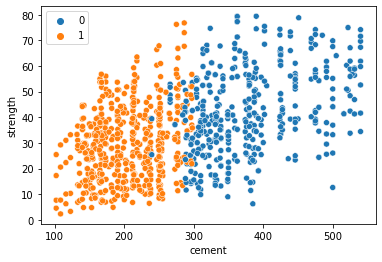

In [33]:
kmeans = KMeans(n_clusters = 2, random_state =2)
clusters = kmeans.fit_predict(df.drop('strength' , axis =1))
sns.scatterplot(x = df['cement'] , y = df['strength'] , hue = clusters)

In [36]:
def clustering(X, tcol, clusters):
    column = list(set(list(X.columns)) - set(X['strength']))
    #column = X.columns
    r = int(len(column) / 2 )
    if r % 2 == 0:
        r = r
    else:
        r += 1
    
    f, ax = plt.subplots(r,2, figsize = (15,15))
    a = 0
    for row in range(r):
        for col in range(0,2):
            if a != len(column):
                ax[row][col].scatter(X[tcol], X[column[a]], c = clusters)
                ax[row][col].set_xlabel(tcol)
                ax[row][col].set_ylabel(column[a])
                a += 1
                
#Plotting clusters between all the independent columns and strength

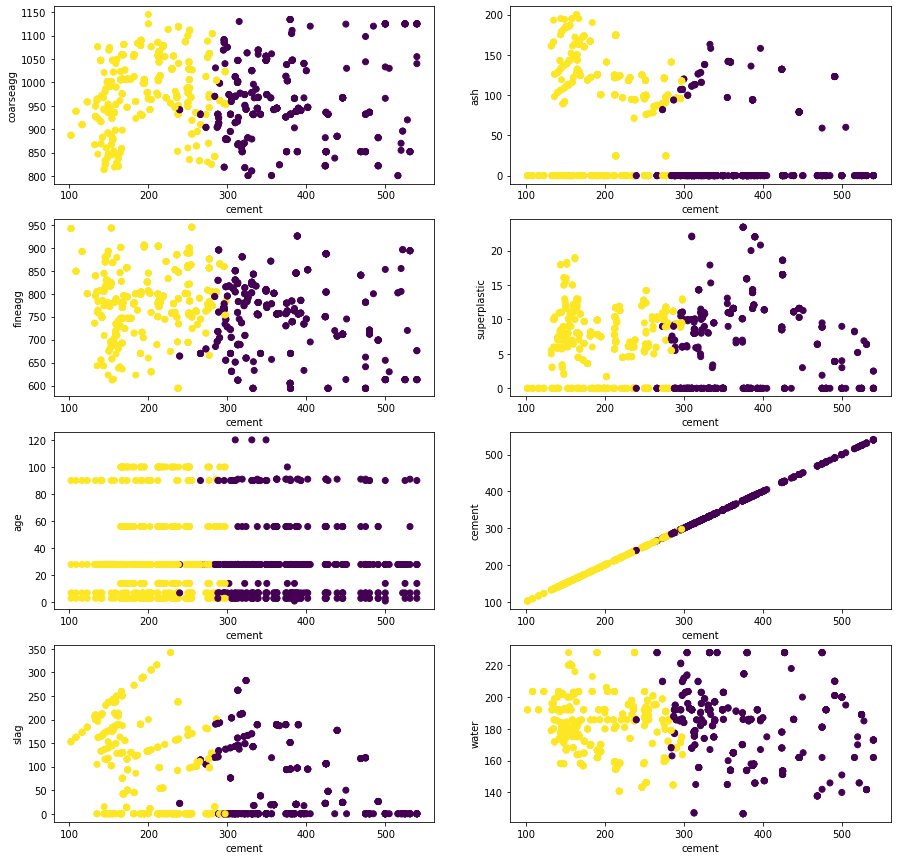

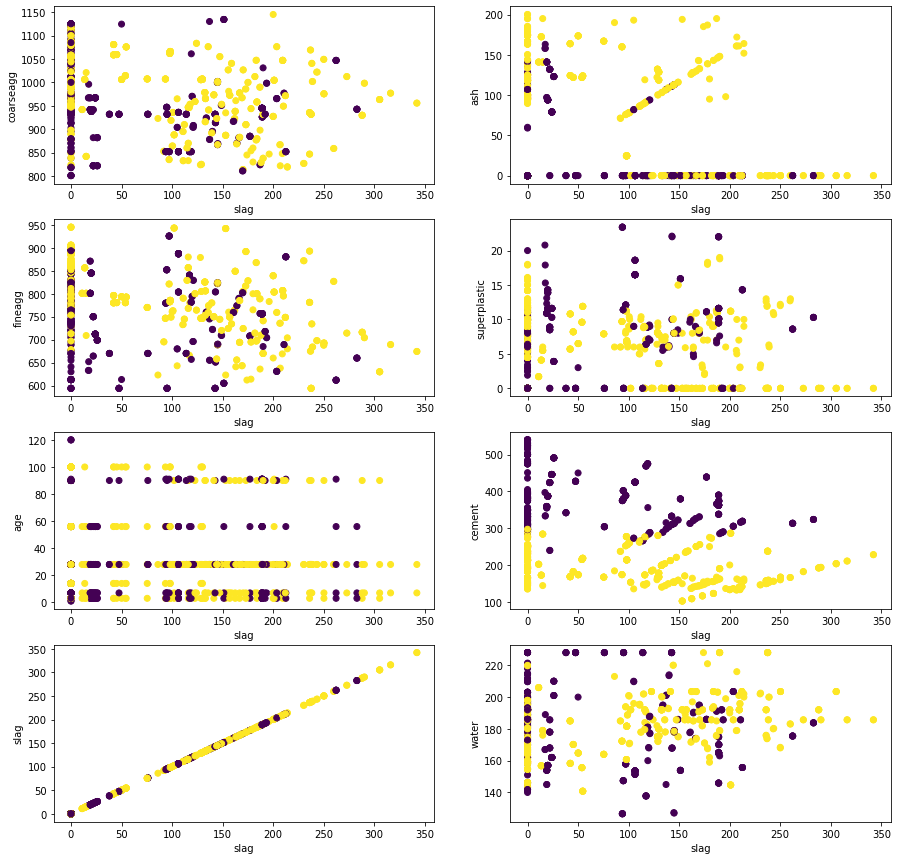

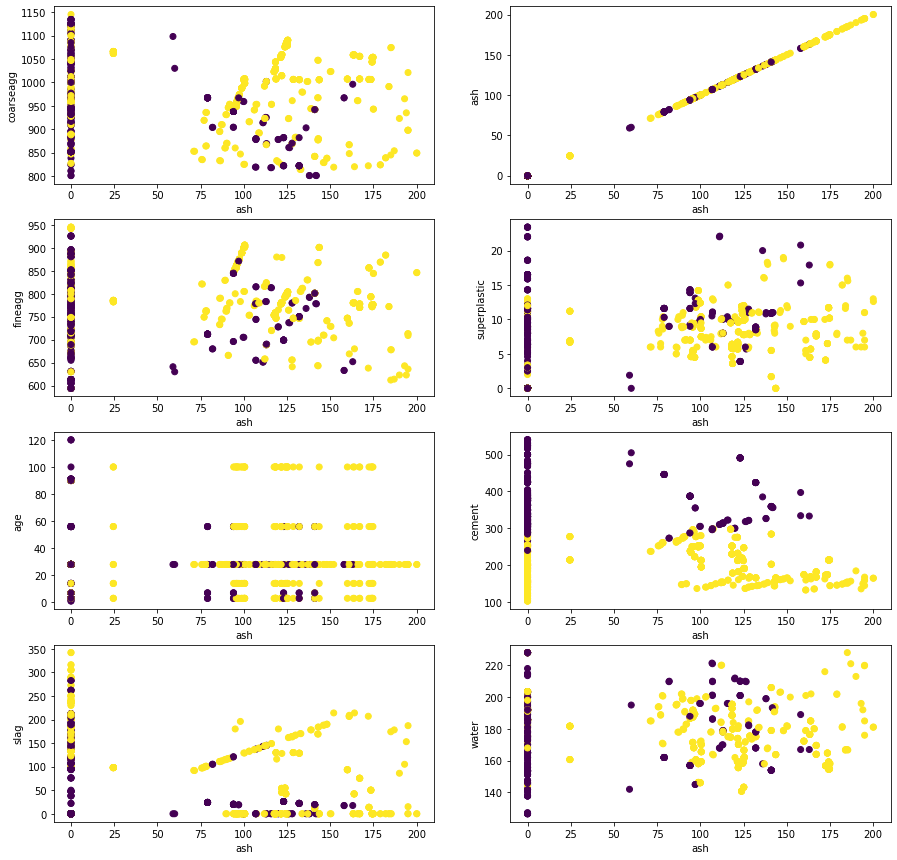

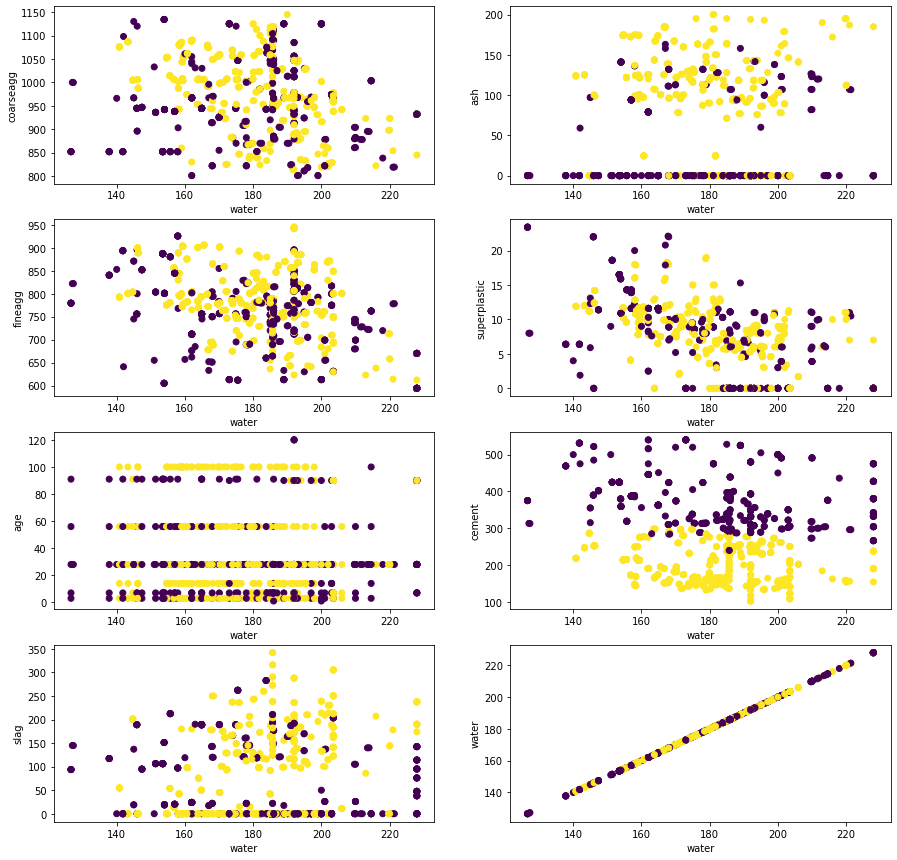

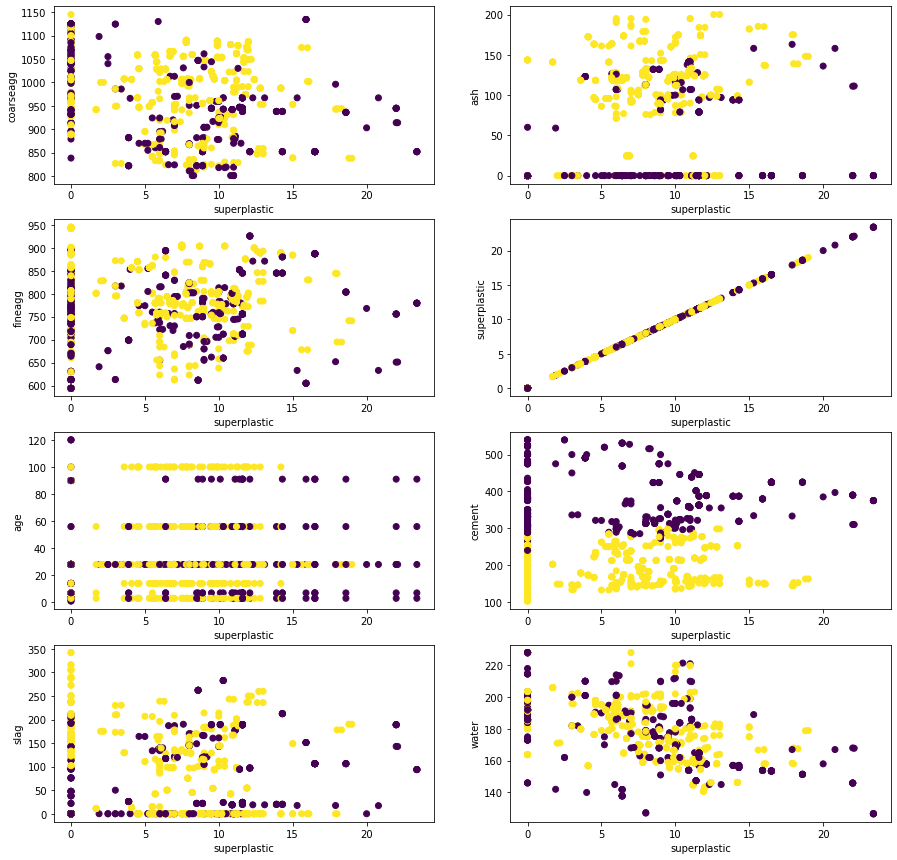

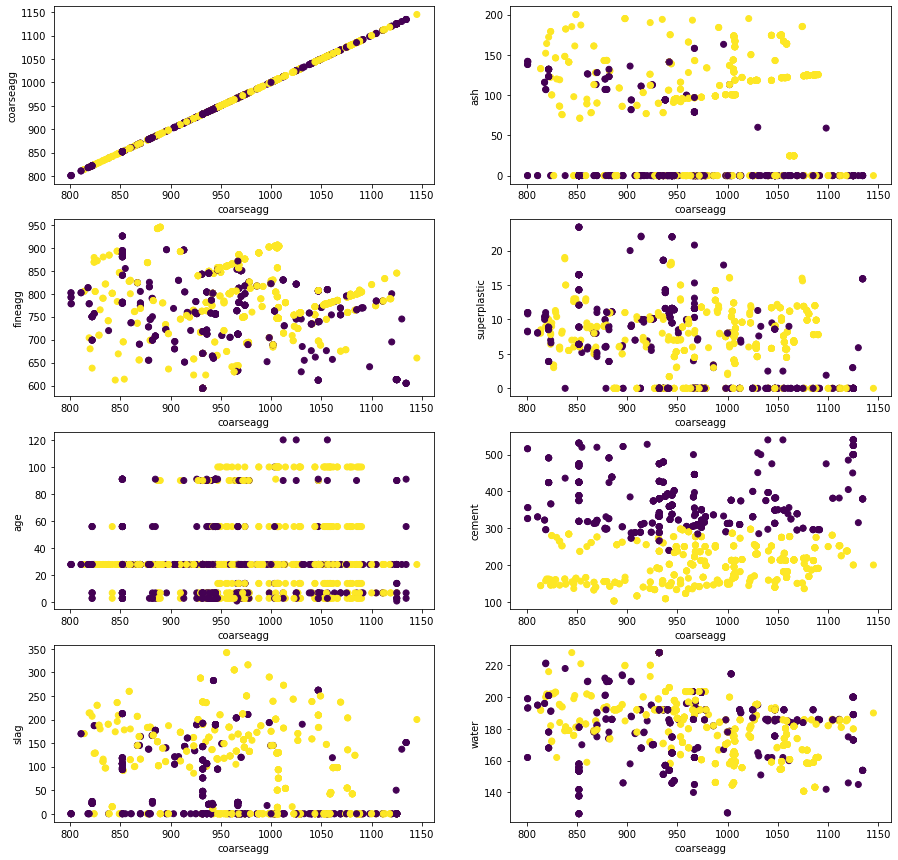

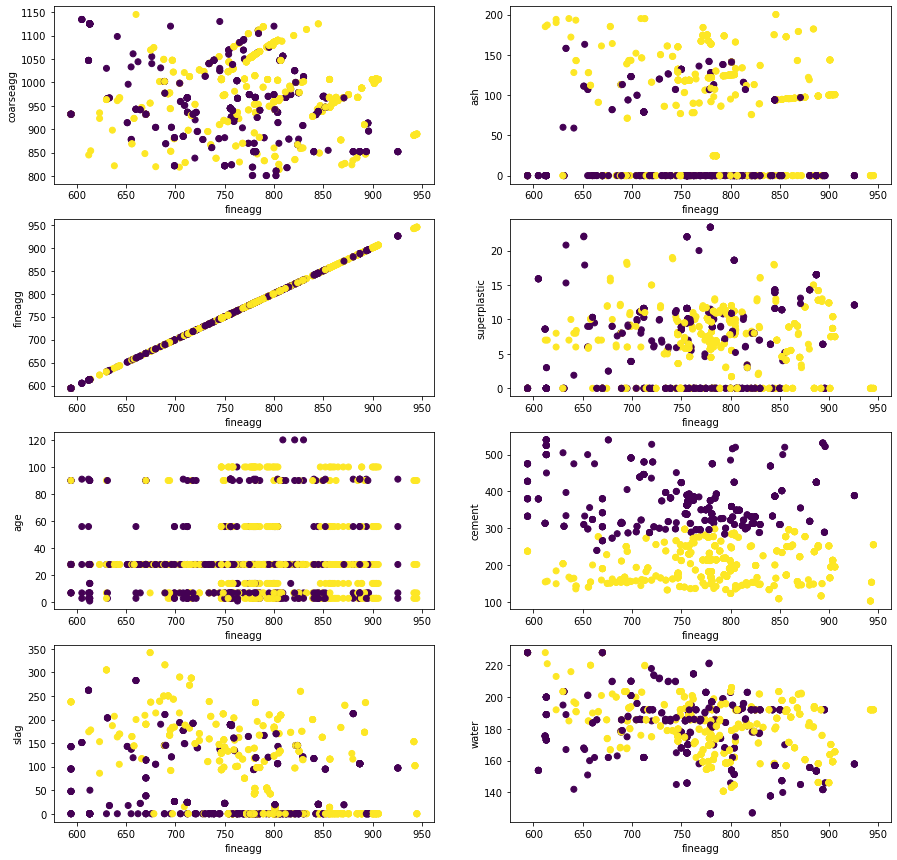

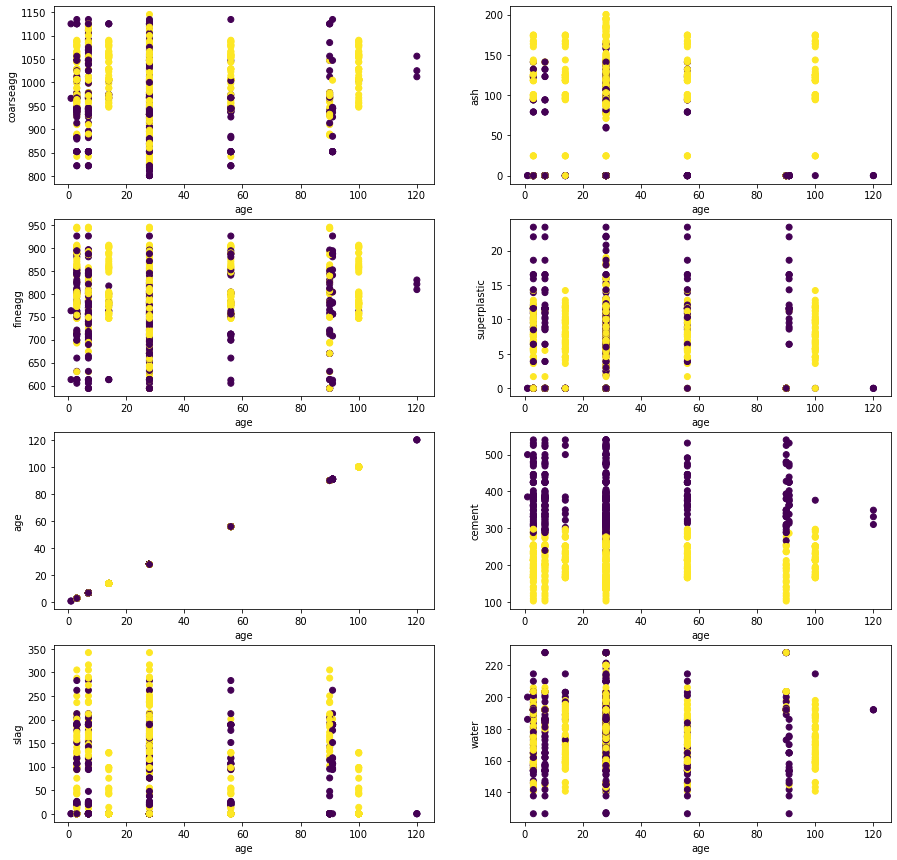

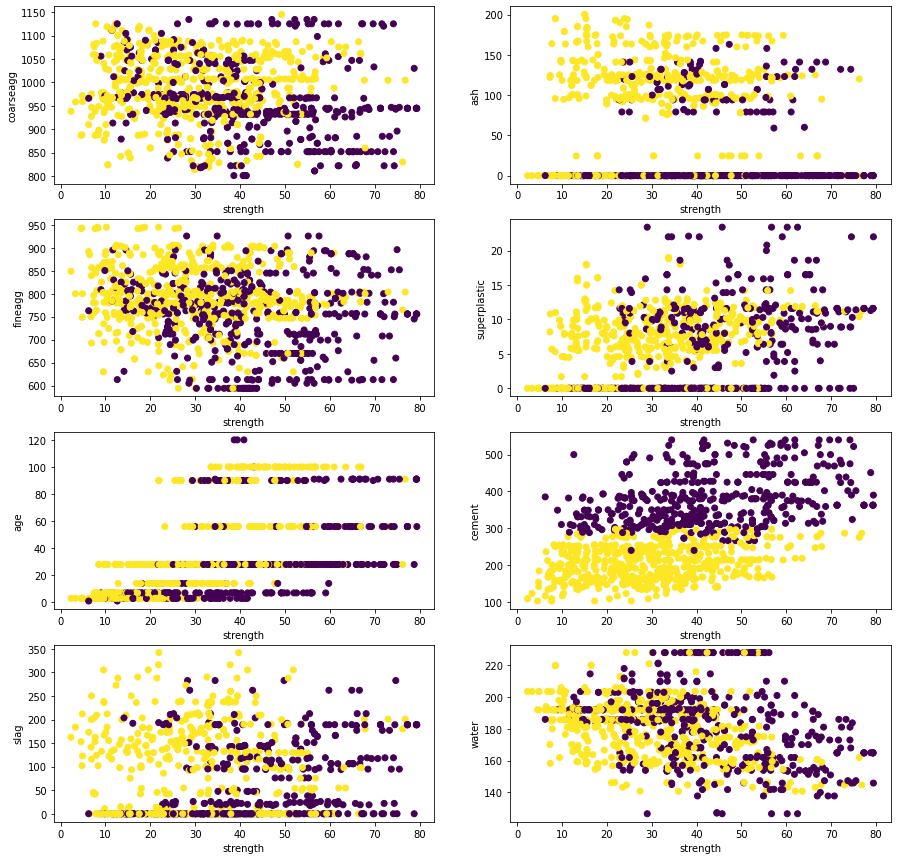

In [37]:
X = df.drop('strength' , axis =1)
for col in df.columns:
    clustering(df,col, clusters)

Analysis:
- cement is forming clusters with all other independent variables.


In [38]:
new_df = df.join(pd.DataFrame(clusters , columns = ['clusters']), how = 'left')
new_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1


In [39]:
new_df['clusters'].value_counts()

1    567
0    463
Name: clusters, dtype: int64

In [40]:
clusters_agg = new_df.groupby('clusters')['cement'].agg(['mean', 'median'])
clusters_agg

,mean,median
clusters,,
0,376.731317,362.6
1,203.132804,202.0


In [41]:
clusters_df = new_df.merge(clusters_agg , on = 'clusters' , how = 'left')
clusters_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,clusters,mean,median
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,1,203.132804,202.0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,1,203.132804,202.0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,1,203.132804,202.0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,0,376.731317,362.6
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,1,203.132804,202.0


In [46]:
multiple_models(clusters_df.drop('clusters' , axis = 1), 'strength')

,Model Name,RMSE,R2 Score
8,XGboost,5.583787,0.887210
5,Random Forest,5.619585,0.885759
7,Gboost,5.865296,0.875550
3,DTR,6.866951,0.829415
9,AdaBoost,8.230073,0.754969
2,Ridge Regression,8.783872,0.720884
0,Linear Regression,8.788817,0.720569
1,Lasso Regression,8.798093,0.719979
6,KNN,9.982205,0.639532
4,SVR,14.324008,0.257763


In [47]:
X = clusters_df.drop(['strength', 'clusters'] , axis = 1)
y = clusters_df['strength']
k_fold_cv(X,y)

,Model Name,CV Accuracy,CV STD
8,XGBoost,0.899436,0.046856
5,Random Forest,0.886554,0.034256
7,Gboost,0.875755,0.044898
3,DTR,0.834793,0.054718
9,AdaBoost,0.740659,0.038340
2,Ridge,0.686641,0.062314
0,Linear Regression,0.686504,0.062213
1,Lasso,0.686437,0.062413
6,KNN,0.669395,0.088242
4,SVR,0.246843,0.044778


In [48]:
cv_post_hpt(X,y)

,Model Name,CV Accuracy,CV STD
8,XGBoost,0.902852,0.038479
5,Random Forest,0.887714,0.035792
7,Gboost,0.875570,0.044784
3,DTR,0.829004,0.054389
9,AdaBoost,0.740356,0.032557
1,Lasso,0.686641,0.062319
2,Ridge,0.686641,0.062315
0,Linear Regression,0.686504,0.062213
6,KNN,0.669395,0.088242
4,SVR,0.246843,0.044778


## Understanding Feature Importance using XGBoost 

In [49]:
x_train , x_test , y_train , y_test = train_and_test_split(clusters_df.drop(['clusters'] , axis = 1) , 'strength')

In [50]:
xgb = XGBRegressor()
xgb.fit(x_train , y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

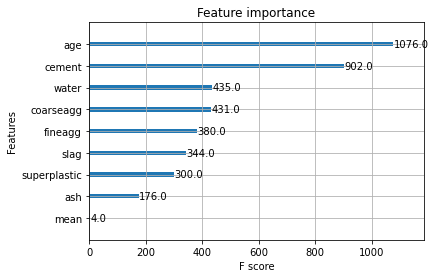

In [51]:
xgboost.plot_importance(xgb)

Analysis on XGBooost Feautre Importance :
- 1 Age and Cement are the two most important for predicting strength of the mixture.


In [57]:
imp_features = clusters_df[['age' , 'cement', 'water', 'coarseagg', 'fineagg', 'strength']]

In [58]:
cv_post_hpt(imp_features.drop('strength' , axis = 1) , imp_features['strength'])

,Model Name,CV Accuracy,CV STD
8,XGBoost,0.884666,0.044019
5,Random Forest,0.863780,0.038083
7,Gboost,0.841333,0.040803
3,DTR,0.801524,0.077277
9,AdaBoost,0.705027,0.036845
1,Lasso,0.657583,0.060431
2,Ridge,0.657579,0.060465
0,Linear Regression,0.657579,0.060465
6,KNN,0.645391,0.079298
4,SVR,0.252828,0.044987


## Building Learning Curve Analysis

In [62]:
def generate_learning_curve(model_name , estimator , X , y):
    train_size , train_score , test_score = learning_curve(estimator = estimator , X = X , y = y , cv = 10)
    train_score_mean = np.mean(train_score , axis = 1)
    test_score_mean = np.mean(test_score , axis = 1)
    plt.plot(train_size , train_score_mean , c = 'blue')
    plt.plot(train_size , test_score_mean , c = 'red')
    plt.xlabel('Samples')
    plt.ylabel('R2 Score')
    plt.title('Learning Curve for ' + model_name)
    plt.legend(('Training R2 Score' , 'Testing R2 Score'))

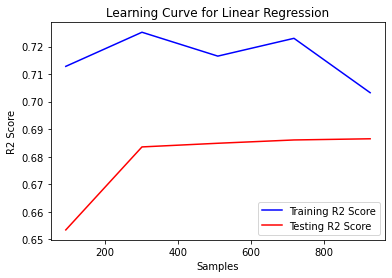

In [66]:
generate_learning_curve('Linear Regression' , LinearRegression() , clusters_df.drop(['clusters' , 'strength'] , axis = 1) , clusters_df['strength'])

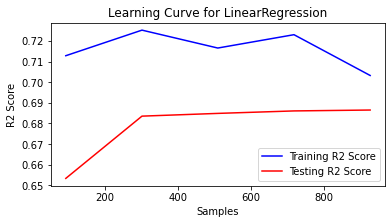

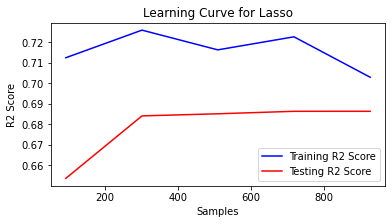

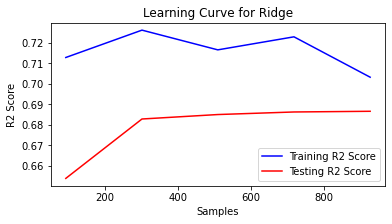

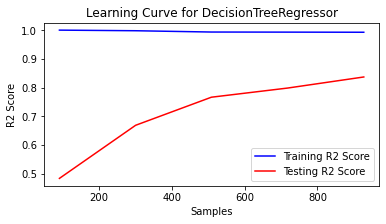

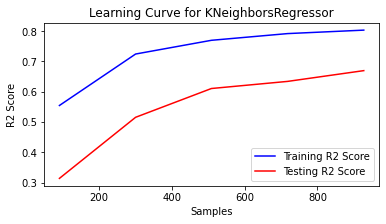

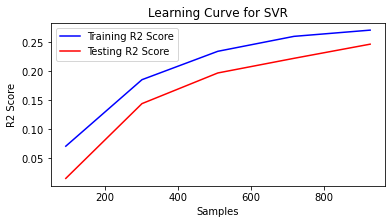

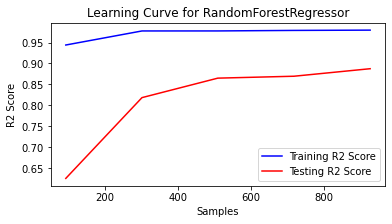

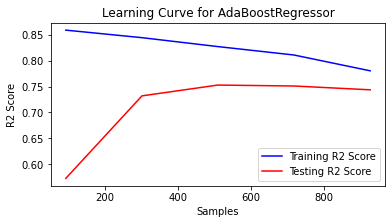

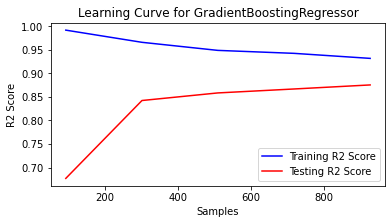

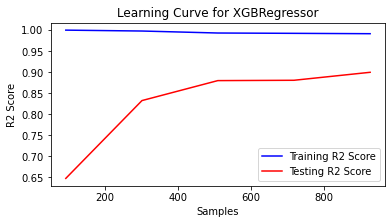

In [76]:
models = [LinearRegression() , Lasso(), Ridge() , DecisionTreeRegressor() , KNeighborsRegressor() ,
            SVR() , RandomForestRegressor() , AdaBoostRegressor() , GradientBoostingRegressor(), 
              XGBRegressor()]
for a , model in enumerate (models):
    fg = plt.figure(figsize= (6 , 3))
    ax = fig.add_subplot(10 , 1 , a+1)
    generate_learning_curve(type(models[a]).__name__ , model , clusters_df.drop(['clusters' , 'strength'] , axis = 1), clusters_df['strength'])